In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.datasets import fetch_california_housing

sns.set(context="notebook", style="whitegrid")

In [47]:
# cargando el dataset
data_housing = fetch_california_housing()

# separando las variables independientes y dependiente
X = data_housing.data
y = data_housing.target

columns_names = data_housing.feature_names + ["target"]

X_y = np.hstack((X, y.reshape(-1,1)))

df_housing = pd.DataFrame(X_y, columns=columns_names)
df_housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Información de las variables

* MedInc: ingreso mediano en el grupo de manzanas.
* HouseAge: edad media de la vivienda en el grupo de bloques.
* AveRooms: número promedio de habitaciones por hogar.
* AveBedrms: número promedio de habitaciones por hogar.
* Population: población del grupo de bloques.
* AveOccup: número promedio de miembros del hogar.
* Latitude: latitud del grupo de bloques.
* Longitude:	longitud del grupo de bloques

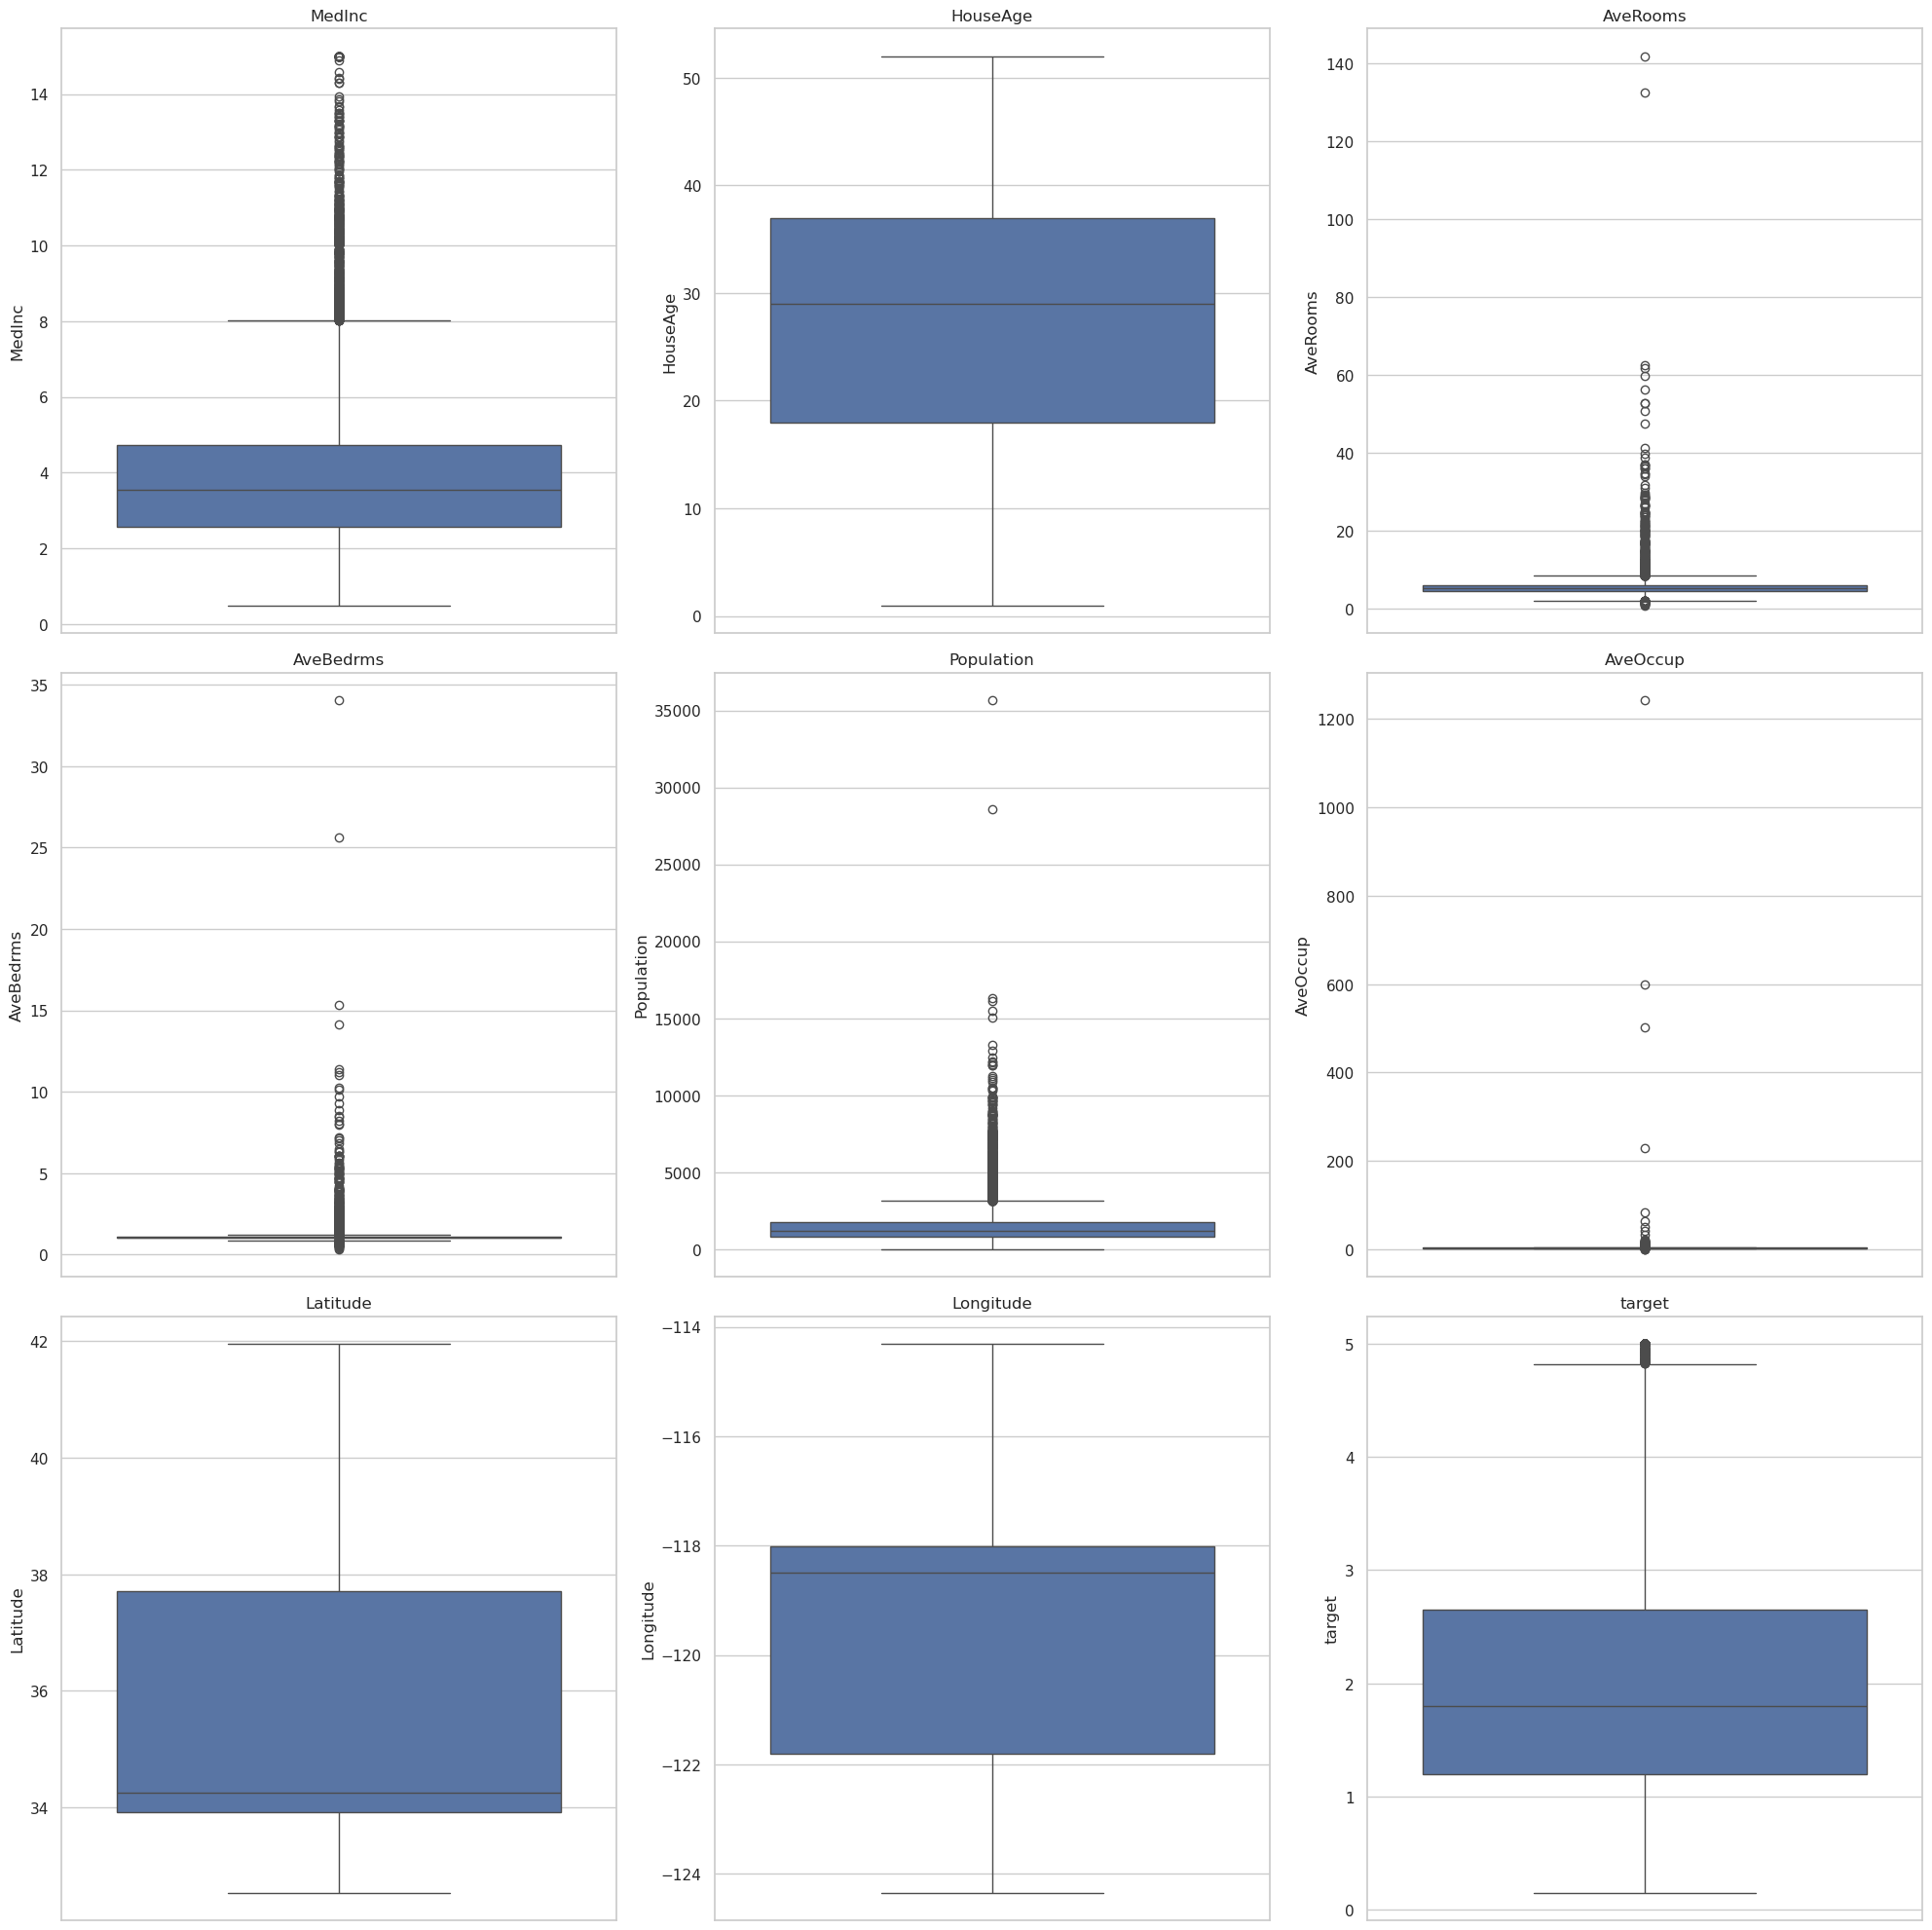

In [48]:
# diagrama de cajas y bigotes de las variables numéricas
fig, ax = plt.subplots(3,3, figsize=(20,20))
ax = ax.flat

for i, col in enumerate(columns_names):
    sns.boxplot(data=df_housing, y=col, ax=ax[i])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [49]:
def del_outliers(df, cols_names):
    if cols_names is None:
        cols_names = df.select_dtypes(exclude="object").columns
    
    df_copy = df.copy()

    for col in cols_names:
        q1 = df_copy[col].quantile(0.25)
        q3 = df_copy[col].quantile(0.75)

        iqr = q3 -q1

        minimo = q1 - 1.5*iqr
        maximo = q3 + 1.5*iqr

        df_sin_outliers = df_copy[(df_copy[col] >= minimo) & (df_copy[col] <= maximo)]

    return df_sin_outliers

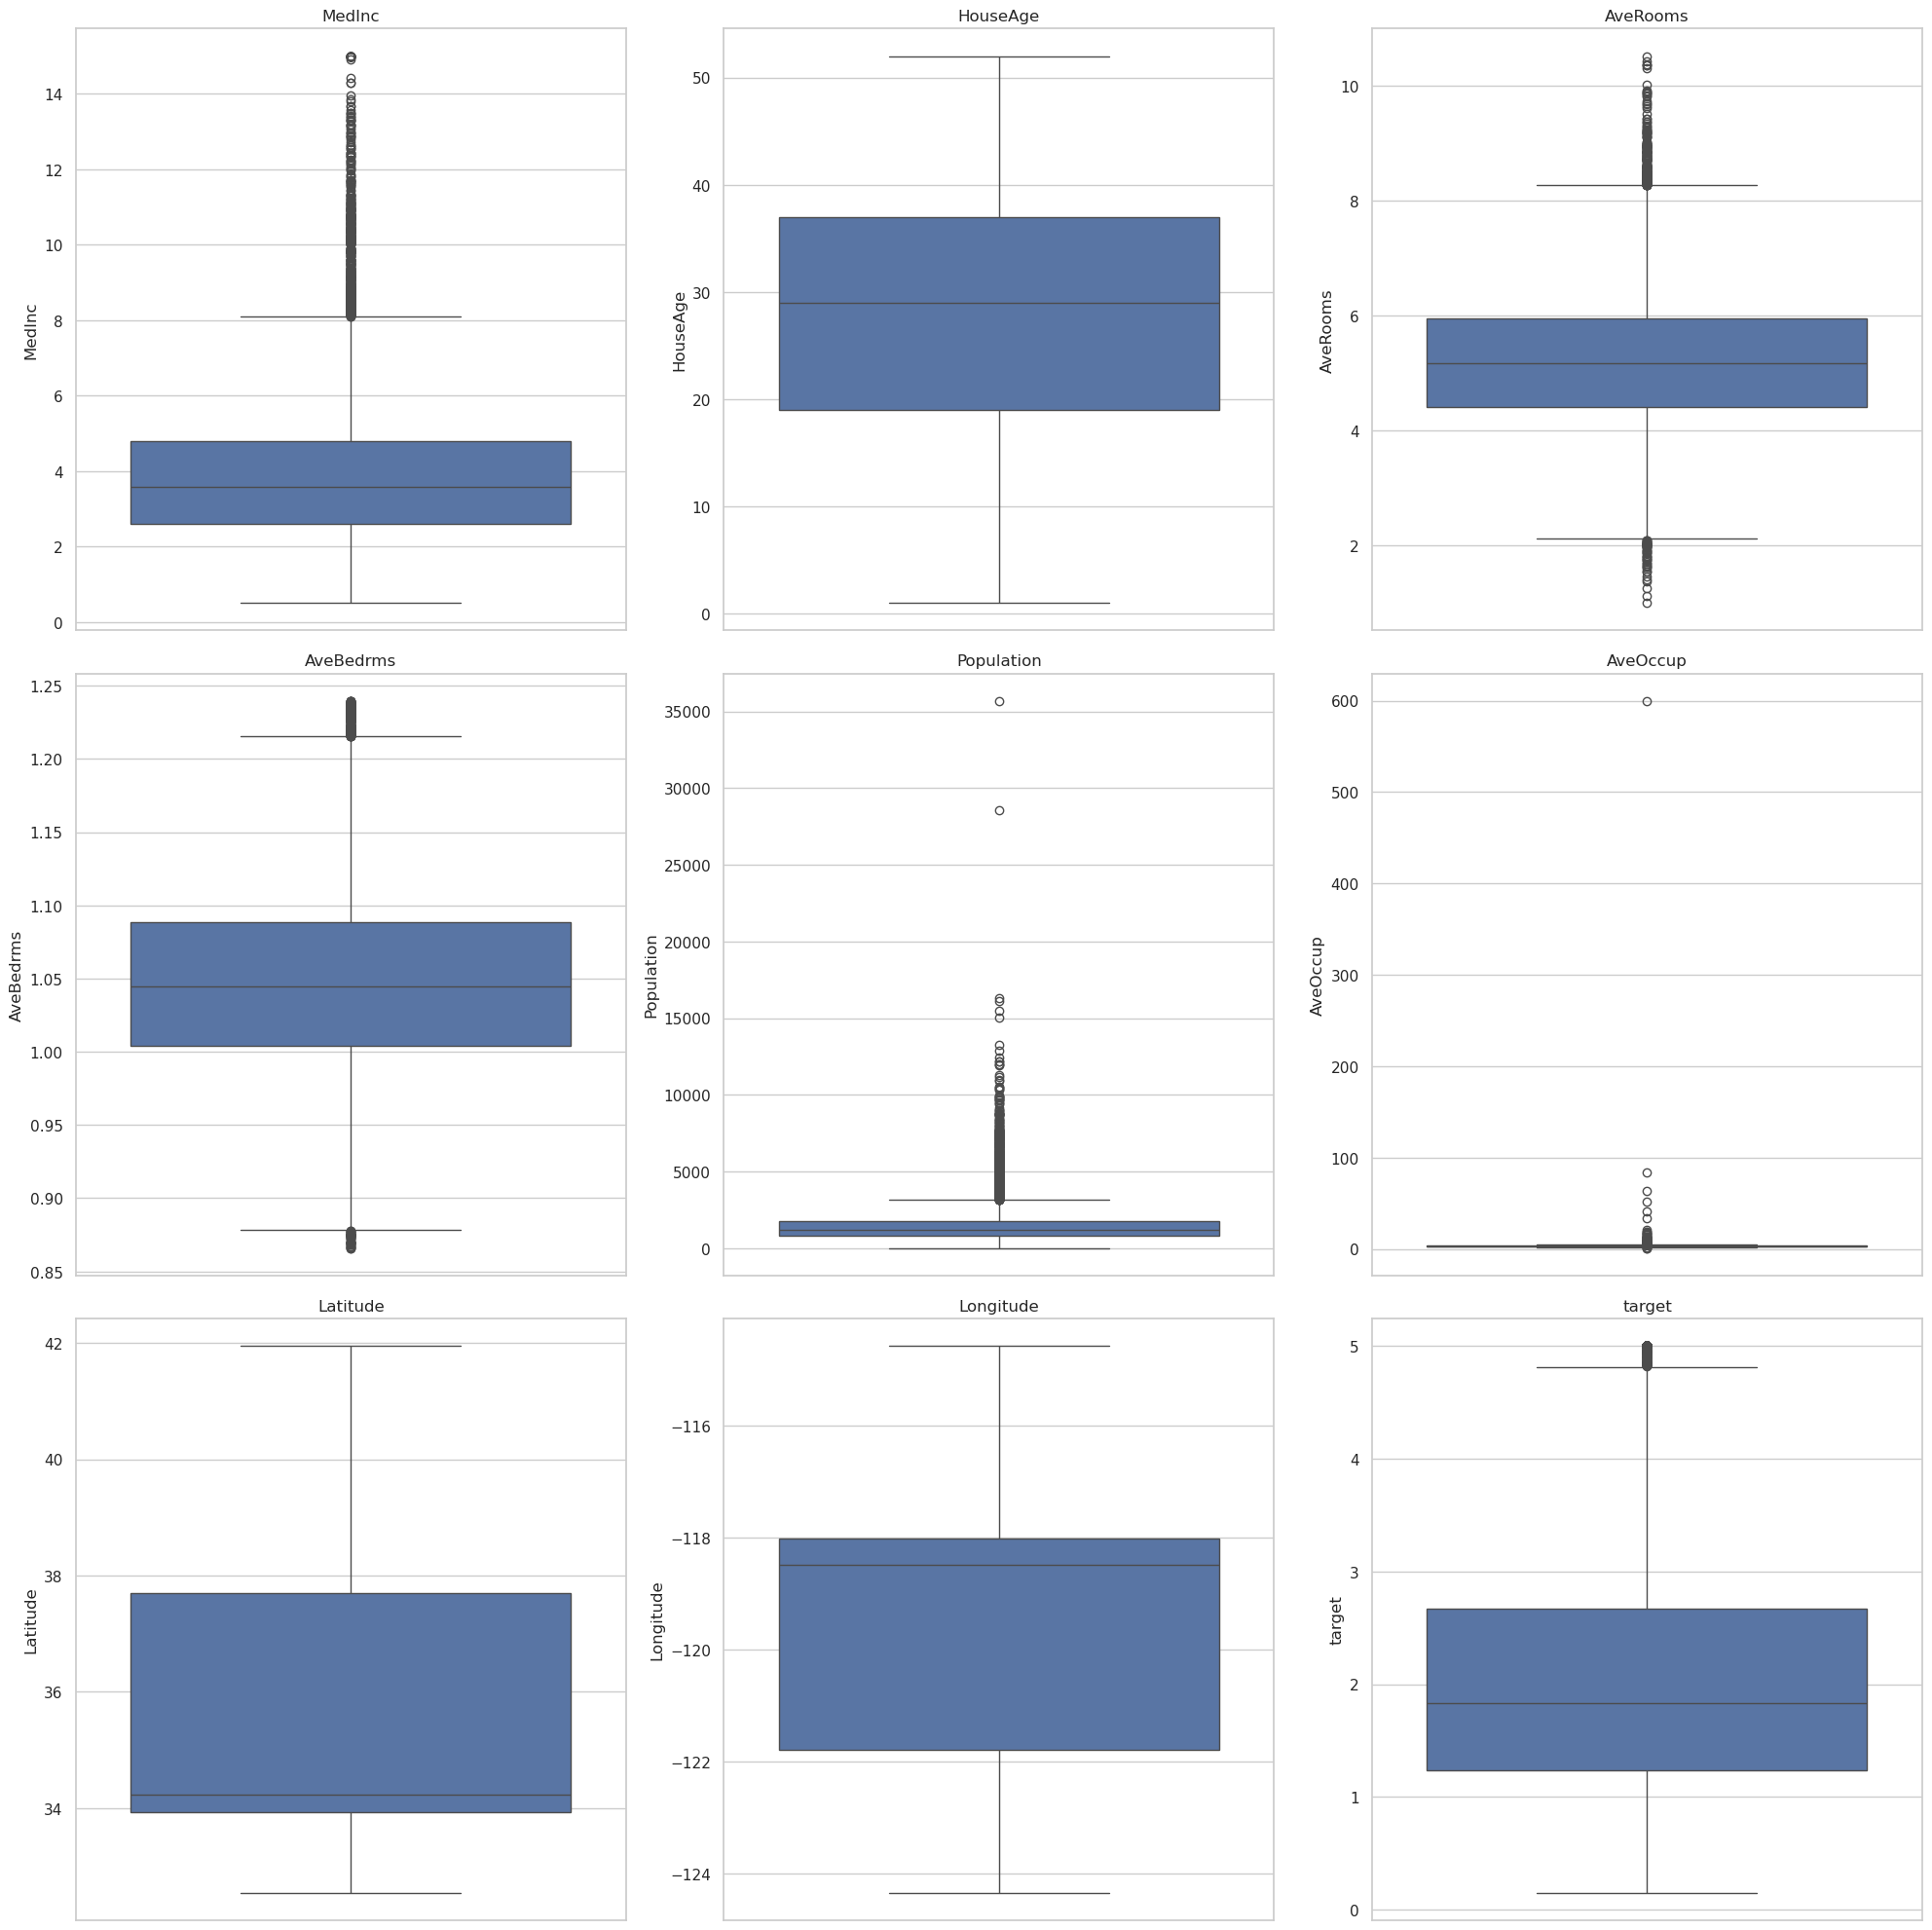

In [50]:
df_out_ave = del_outliers(df_housing, ["AveRooms", 'AveBedrms'])

fig, ax = plt.subplots(3,3, figsize=(20,20))
ax = ax.flat

for i, col in enumerate(columns_names):
    sns.boxplot(data=df_out_ave, y=col, ax=ax[i])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [51]:
def matriz_corr(df):
    df_corr = df.stack().reset_index()

    df_corr.columns= ["variable_1", "variable_2", "r"]
    df_corr = df_corr.loc[df_corr["variable_1"] != df_corr["variable_2"], :]
    df_corr["abs_r"] = np.abs(df_corr["r"])
    df_corr = df_corr.sort_values("r", ascending=False).reset_index(drop=True)
    return df_corr

  variable_1 variable_2         r     abs_r
0     MedInc   AveRooms  0.745442  0.745442
1   AveRooms     MedInc  0.745442  0.745442
2     target     MedInc  0.693077  0.693077
3     MedInc     target  0.693077  0.693077
4   AveRooms     target  0.377244  0.377244
5     target   AveRooms  0.377244  0.377244
6   Latitude   AveRooms  0.108290  0.108290
7   AveRooms   Latitude  0.108290  0.108290
8     target   HouseAge  0.103610  0.103610
9   HouseAge     target  0.103610  0.103610


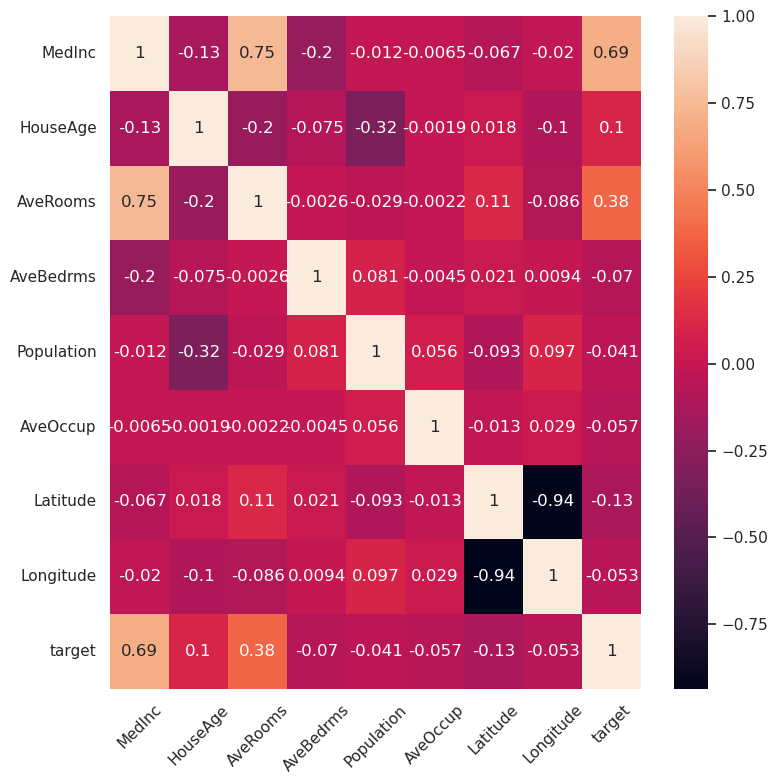

In [52]:
print(matriz_corr(df_out_ave.corr()).head(10))

plt.figure(figsize=(8,8))
sns.heatmap(df_out_ave.corr(), annot=True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [53]:
# Designando las variables independientes y dependientes
X = df_out_ave.drop("target", axis=1)
y = df_out_ave["target"].values.reshape(-1,1)

# separando los datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sc_X = StandardScaler()
X_train_sc = sc_X.fit_transform(X_train)
X_test_sc = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train_sc = sc_y.fit_transform(y_train)
y_test_sc = sc_y.transform(y_test)

## Ridge

In [54]:
# creando el modelo con Ridge
model_ridge = RidgeCV(
    alphas = np.logspace(-1,8,200),
    fit_intercept=True,
    store_cv_results=True
)

# realizando el entrenamiento
_ = model_ridge.fit(X_train_sc, y_train_sc)

In [55]:
# evolucion de los coeficientes del alpha
alphas = model_ridge.alphas
coefs = []

for alpha in alphas:
    model_temp = Ridge(alpha=alpha)
    model_temp.fit(X_train_sc, y_train_sc)
    coefs.append(model_temp.coef_)

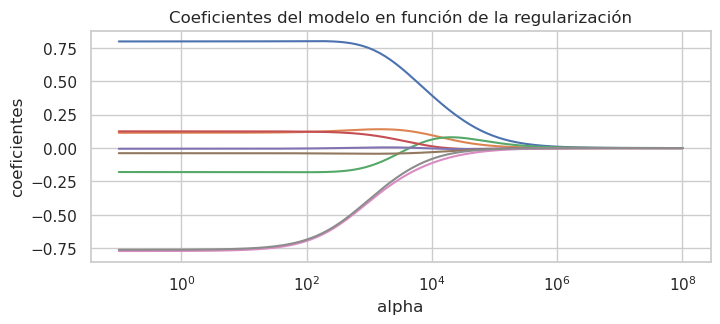

In [56]:
# diagrama de la evolución de los coeficientes de acuerdo al valor del alpha
plt.figure(figsize=(8,3))
plt.plot(alphas, coefs)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel('coeficientes')
plt.title('Coeficientes del modelo en función de la regularización')
plt.show()


In [57]:
# realizando la prediccion con los datos de prueba
y_pred_ridge = model_ridge.predict(X_test_sc)

In [59]:
# calculando la métrica r2
r2_ridge = r2_score(y_test_sc, y_pred_ridge)
print(f"El valor del coeficiente de determinación es: {np.round(r2_ridge,3)}")
mse_ridge = mean_squared_error(y_test_sc, y_pred_ridge)
print(f"El valor de la suma cuadrática media es: {np.round(mse_ridge,3)}")

El valor del coeficiente de determinación es: 0.583
El valor de la suma cuadrática media es: 0.432


In [60]:
# calculando una predicción
dato_prueba = X.iloc[0, :].values.reshape(1, -1)
dato_prueba = pd.DataFrame(dato_prueba, columns=data_housing.feature_names)
dato_prueba_sc = sc_X.transform(dato_prueba)
predict_sc = model_ridge.predict(dato_prueba_sc)
predict_real = sc_y.inverse_transform(predict_sc.reshape(1,-1))
print(f"La predicción del valor de prueba es: {predict_real[0][0].round(2)}")

La predicción del valor de prueba es: 3.91


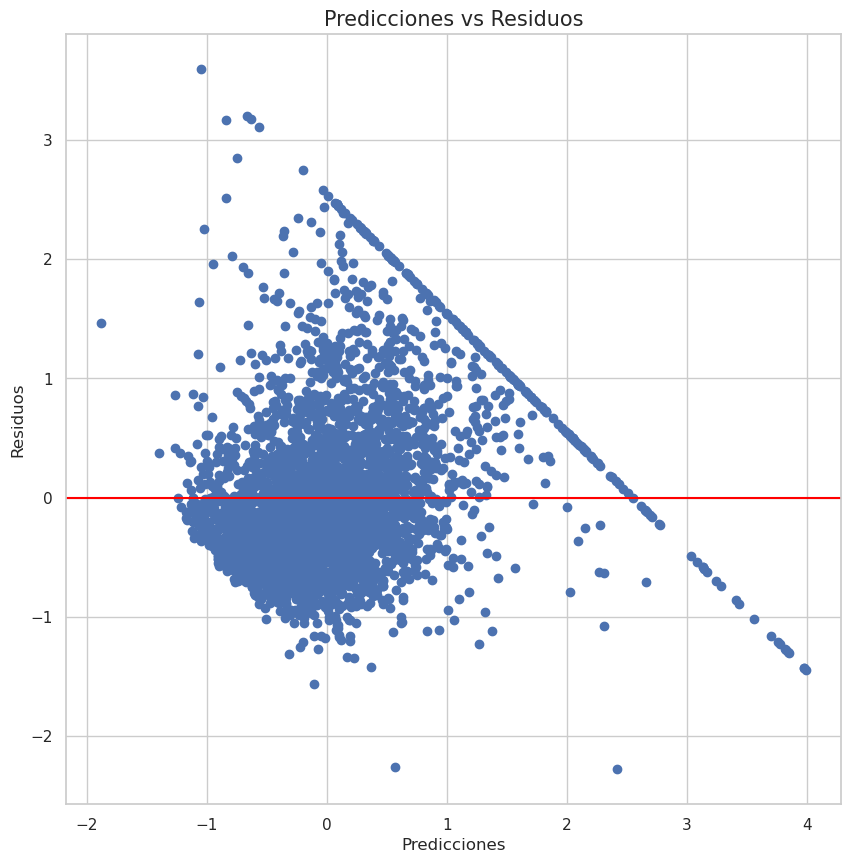

In [61]:
# graficando los errores
plt.figure(figsize=(10,10))
residuos = np.subtract(y_test_sc.reshape(-1),y_pred_ridge)
plt.scatter(y_pred_ridge, residuos)
plt.axhline(y=0, color="red")
plt.title("Predicciones vs Residuos", size=15)
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.show()

## Lasso

In [62]:
model_lasso = LassoCV(
    alphas=np.logspace(-3, 8, 200),
    fit_intercept=False,
    cv=3
)

_ = model_lasso.fit(X_train_sc, y_train_sc.ravel())

In [63]:
alphas = model_lasso.alphas_
coefs = []

for alpha in alphas:
    model_temp = Lasso(alpha=alpha)
    model_temp.fit(X_train_sc, y_train_sc.ravel())
    coefs.append(model_temp.coef_)

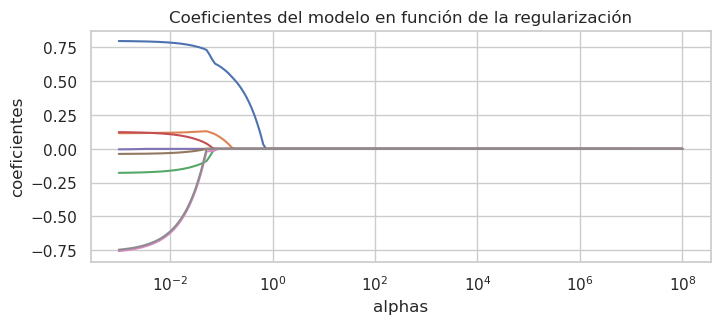

In [64]:

plt.figure(figsize=(8,3))
plt.plot(alphas, coefs)
plt.xscale("log")
plt.xlabel("alphas")
plt.ylabel("coeficientes")
plt.title('Coeficientes del modelo en función de la regularización')
plt.show()

In [65]:
# prediccciones
y_pred_lasso = model_lasso.predict(X_test_sc)

In [66]:
# r2
r2_lasso = r2_score(y_test_sc, y_pred_lasso)
print(f"El valor del coeficiente de determinación es: {np.round(r2_lasso,3)}")
# mse
mse_lasso = mean_squared_error(y_test_sc, y_pred_lasso)
print(f"El valor de la suma cuadrática media es: {np.round(mse_lasso,3)}")

El valor del coeficiente de determinación es: 0.599
El valor de la suma cuadrática media es: 0.415


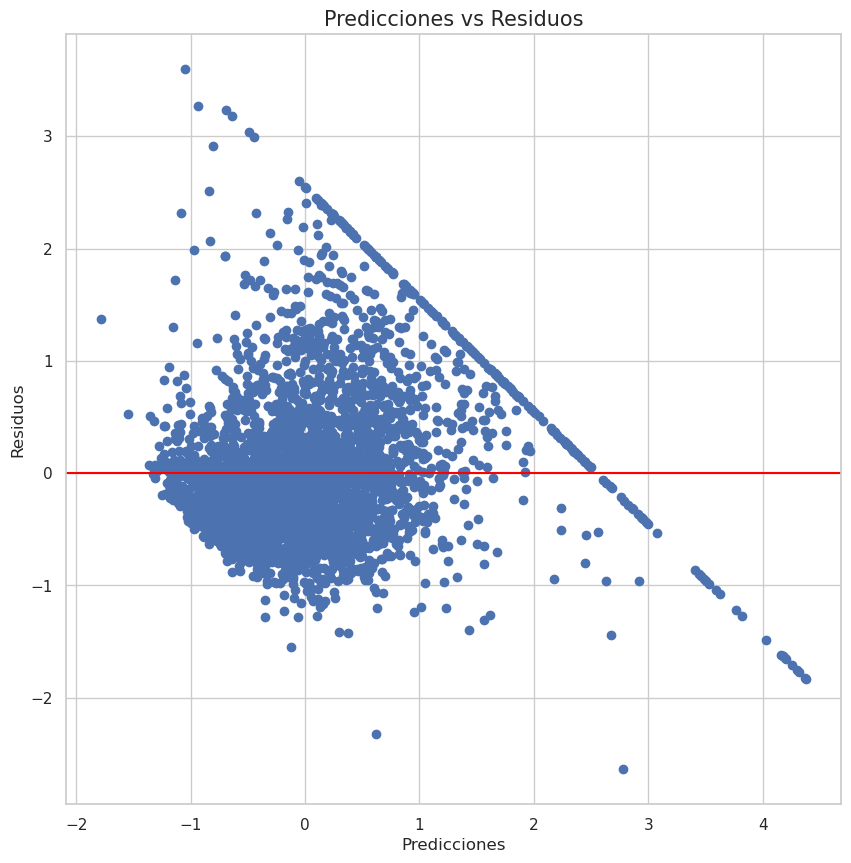

In [68]:
residuos = np.subtract(y_test_sc.reshape(-1), y_pred_lasso)
plt.figure(figsize=(10,10))
plt.scatter(y_pred_lasso, residuos)
plt.axhline(y=0, color="red")
plt.title("Predicciones vs Residuos", size=15)
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.show()

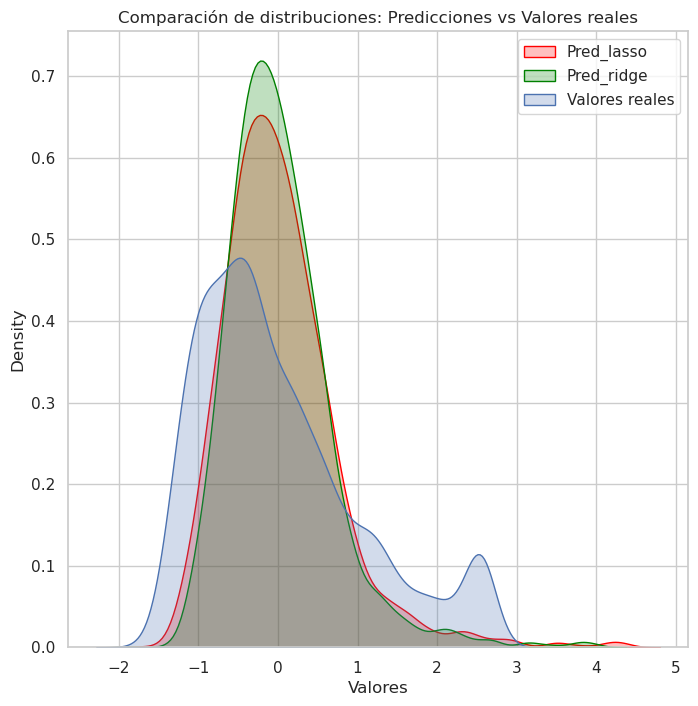

In [70]:
plt.figure(figsize=(8,8))
sns.kdeplot(y_pred_lasso, fill=True, color="red", label="Pred_lasso")
sns.kdeplot(y_pred_ridge, fill=True, color="green", label="Pred_ridge")
sns.kdeplot(y_test_sc, fill=True, color="blue", label="Valores reales")
plt.legend()
plt.title("Comparación de distribuciones: Predicciones vs Valores reales")
plt.xlabel("Valores")
plt.grid(True)
plt.show()